<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico I - Estadística </h1>
<h3> Análisis y Visualización de Datos - 2019 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10. Usaremos una [versión ya limpia del dataset](https://www.kaggle.com/gsutters/the-human-freedom-index/home) que pueden descargar desde Kaggle.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con dos estimadores principales: *hf_score* que hace referencia a Human Freedom, y *ef_score* que hace referencia a Economic Freedom. Estos dos estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [223]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats

In [57]:
rc_params = {
    'axes.labelsize': 22,
    'figure.figsize':(10.5,8.5), 
    'legend.fontsize': 20,
    'axes.linewidth': 3,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'xtick.major.width': 4,
    'xtick.major.size': 10,
    'xtick.minor.visible': True,
    'xtick.minor.width': 3,
    'xtick.minor.size': 5,
    'ytick.major.width': 4,
    'ytick.major.size': 10,
    'ytick.minor.visible': True,
    'ytick.minor.width': 3,
    'ytick.minor.size': 5,
    'axes.titlesize': 22
}
sb.set(rc=rc_params)

In [4]:
dataset = pd.read_csv('../datasets/hfi_cc_2018.csv')
dataset.shape

(1458, 123)

In [5]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'pf_rol_procedural',
       'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide',
       'pf_ss_disappearances_disap',
       ...
       'ef_regulation_business_bribes', 'ef_regulation_business_licensing',
       'ef_regulation_business_compliance', 'ef_regulation_business',
       'ef_regulation', 'ef_score', 'ef_rank', 'hf_score', 'hf_rank',
       'hf_quartile'],
      dtype='object', length=123)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [6]:
important_cols = ['year', 'ISO_code', 'countries', 'region']

important_cols += [col for col in dataset.columns if 'pf_identity' in col]

important_cols += [
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

In [171]:
dataset = dataset[important_cols]
dataset[important_cols].head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_parental_marriage,pf_identity_parental_divorce,pf_identity_parental,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,ef_score,ef_rank,hf_score,hf_rank
0,2016,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,6.250000,7.54,34.0,7.568140,48.0
1,2016,DZA,Algeria,Middle East & North Africa,NaN,0.0,5.0,2.5,0.0,0.0,0.0,0.0,0.833333,4.99,159.0,5.135886,155.0
2,2016,AGO,Angola,Sub-Saharan Africa,10.0,10.0,10.0,10.0,0.0,0.0,0.0,10.0,7.500000,5.17,155.0,5.640662,142.0
3,2016,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,4.84,160.0,6.469848,107.0
4,2016,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,8.000000,7.57,29.0,7.241402,57.0


## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. ¿Tiene sentido calcular la moda? 
  3. ¿Son todos los valores de *pf_identity*  y *hf_score* directamente comparables? ¿Qué otra variable podría influenciarlos?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? ¿Los outliers, son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

**1.1) Rango para variables**
  

In [17]:
from pandas.api.types import is_numeric_dtype

data = []
for column in important_cols:
    if not pd.isnull(dataset[column][0]) and is_numeric_dtype(dataset[column][0]):
        rango = max(dataset[column]) - min(dataset[column])
        data.append([column, rango])
        #print("rango para variable {0} = {1}".format(column, rango))
    else:
        print("{0} No contiente valores numericos".format(column))
        
pd.DataFrame(data, columns=['variable', 'rango'])

ISO_code No contiente valores numericos
countries No contiente valores numericos
region No contiente valores numericos


,variable,rango
0,year,8.000000
1,pf_identity_legal,10.000000
2,pf_identity_parental_marriage,10.000000
3,pf_identity_parental_divorce,10.000000
4,pf_identity_parental,10.000000
5,pf_identity_sex_male,10.000000
6,pf_identity_sex_female,10.000000
7,pf_identity_sex,10.000000
8,pf_identity_divorce,10.000000
9,pf_identity,10.000000


**1.2) Media, Mediana y Desviación Estandar  para variables  pf_identity y hf_score**  

In [19]:
SEPARATOR = "="*80
latin_america_data = dataset[dataset['region'] == 'Latin America & the Caribbean'].copy()

print(SEPARATOR)
# MEAN
pf_identity_latin_america_mean = latin_america_data['pf_identity'].mean()
pf_identity_global_mean = dataset['pf_identity'].mean()
print("Media para la variable pf_identity en LatinAmerica = {0}".format(pf_identity_latin_america_mean))
print("Media para la variable pf_identity en todo el mundo = {0}".format(pf_identity_global_mean))

hf_score_latin_america_mean = latin_america_data['hf_score'].mean()
hf_score_global_mean = dataset['hf_score'].mean()
print("Media para la variable hf_score en LatinAmerica = {0}".format(hf_score_latin_america_mean))
print("Media para la variable hf_score en todo el mundo = {0}".format(hf_score_global_mean))

print(SEPARATOR)
#STD DEV
pf_identity_latin_america_std = latin_america_data['pf_identity'].std()
pf_identity_global_std = dataset['pf_identity'].std()
print("Desviación Estandar para la variable pf_identity en LatinAmerica = {0}".format(pf_identity_latin_america_std))
print("Desviación Estandar para la variable pf_identity en todo el mundo = {0}".format(pf_identity_global_std))

std_hf_score_latin_america = latin_america_data['hf_score'].std()
std_hf_score_rest_of_world = dataset['hf_score'].std()
print("Desviación Estandar para la variable hf_score en LatinAmerica = {0}".format(std_hf_score_latin_america))
print("Desviación Estandar para la variable hf_score en todo el mundo = {0}".format(std_hf_score_rest_of_world))

print(SEPARATOR)
# MEDIAN
pf_identity_latin_america_median = latin_america_data['pf_identity'].median()
pf_identity_global_median = dataset['pf_identity'].median()
print("Mediana para la variable pf_identity en LatinAmerica = {0}".format(pf_identity_latin_america_median))
print("Mediana para la variable pf_identity en todo el mundo = {0}".format(pf_identity_global_median))

hf_score_latin_america_median = latin_america_data['hf_score'].median()
hf_score_global_median = dataset['hf_score'].median()
print("Mediana para la variable hf_score en LatinAmerica = {0}".format(hf_score_latin_america_median))
print("Mediana para la variable hf_score en todo el mundo = {0}".format(hf_score_global_median))


Media para la variable pf_identity en LatinAmerica = 8.765086206909483
Media para la variable pf_identity en todo el mundo = 7.33417997096807
Media para la variable hf_score en LatinAmerica = 7.047981929952582
Media para la variable hf_score en todo el mundo = 6.9934437555145
Desviación Estandar para la variable pf_identity en LatinAmerica = 1.7117319741534658
Desviación Estandar para la variable pf_identity en todo el mundo = 3.159472661477449
Desviación Estandar para la variable hf_score en LatinAmerica = 0.6089040915687837
Desviación Estandar para la variable hf_score en todo el mundo = 1.0258111611874141
Mediana para la variable pf_identity en LatinAmerica = 10.0
Mediana para la variable pf_identity en todo el mundo = 9.166666667000001
Mediana para la variable hf_score en LatinAmerica = 7.02804474
Mediana para la variable hf_score en todo el mundo = 6.923840432999999


Los valores de las variables estudiadas son continuos, por lo cual no tiene sentido calcular la Moda.


**1.3)** 

Los promedios y medianas de las variables **pf_identity** y **hf_score** presentan valores cercanos entre sitanto a nivel global como a nivel LA, aunque los valores promedios para la variable **pf_identity** presentan un sesgo hacia los valores superiores del rango(10), y en el caso de la mediana conciden con el valor maximo.

Por otro lado los promedios de la variable **hf_score** (tanto globalmente como para LA) son levemente superiores al valor medio posible (~6-7.x  > 5) y coinciden con las medianas (tanto globalmente como para LA).

Tambien se observa que la desviación estandar es mayor para la variable **hf_score** que respecto a la variable pf_identity (globalmente y para la region LA), lo que indica la presencia de valores mas sesgados para esta variable,  mientras que la variable **pf_identity** tiene valores mas concentrados  y cercanos a su valor medio. 

Por dichas diferencias observados en los calculos de medias y desviaciones se concluye que ambas variables no son directamente comparables.

La variable economic freedom **ef_score** tambien incide sobre la variable **pf_freedom**.

**1.4)**

Se pueden remover los valores NaN con el siguiente comando:

In [442]:
dataset['pf_identity'].copy().dropna()

0        6.250000
1        0.833333
2        7.500000
3       10.000000
4        8.000000
5        9.250000
6       10.000000
7        6.250000
8       10.000000
9        3.333333
10       1.250000
11       5.000000
12       8.000000
13       9.250000
14      10.000000
15      10.000000
16       3.750000
17      10.000000
18       9.250000
19       4.250000
20       7.500000
21       1.666667
22       9.250000
23      10.000000
24       5.833333
25       8.333333
26       5.000000
27       9.250000
28      10.000000
29       8.333333
          ...    
1420     7.500000
1422     0.000000
1423    10.000000
1425     5.000000
1426     7.500000
1427    10.000000
1428    10.000000
1429     7.500000
1430    10.000000
1431     2.500000
1435    10.000000
1436    10.000000
1437     2.500000
1438    10.000000
1440     2.500000
1441    10.000000
1443     2.500000
1444     5.000000
1445     5.000000
1446    10.000000
1447     2.500000
1448    10.000000
1449     0.000000
1450    10.000000
1451    10

**1.5) Detección de ouliers para las variables pf_dentity y hf_score**  

**pf_dentity:**
 

In [47]:
df1 = dataset[['pf_identity', 'region']].copy()
df1['region'] = 'Global'
df2 = latin_america_data[['pf_identity', 'region']].copy()
df2['region'] = 'LA'
df3 = df1.append(df2).copy()

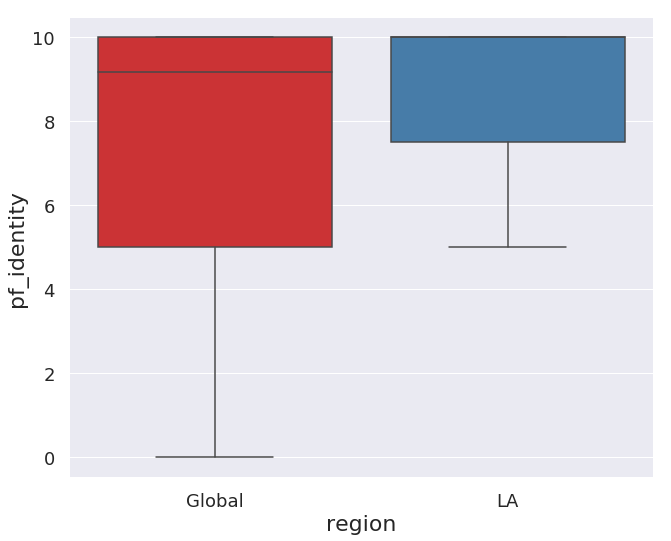

In [49]:
sb.boxplot(x=df3['region'], y=df3['pf_identity'], data=df3, palette="Set1")
plt.show()

**hf_score:**
  

In [51]:
df4 = dataset[['hf_score', 'region']].copy()
df4['region'] = 'Global'
df5 = latin_america_data[['hf_score', 'region']].copy()
df5['region'] = 'LA'
df6 = df4.append(df5).copy()

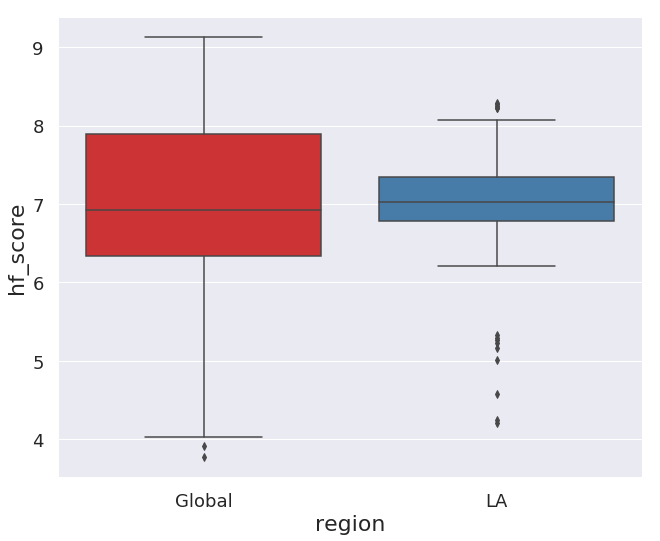

In [52]:
sb.boxplot(x=df6['region'], y=df6['hf_score'], data=df6, palette="Set1")
plt.show()

**hf_score sin outliers:**  

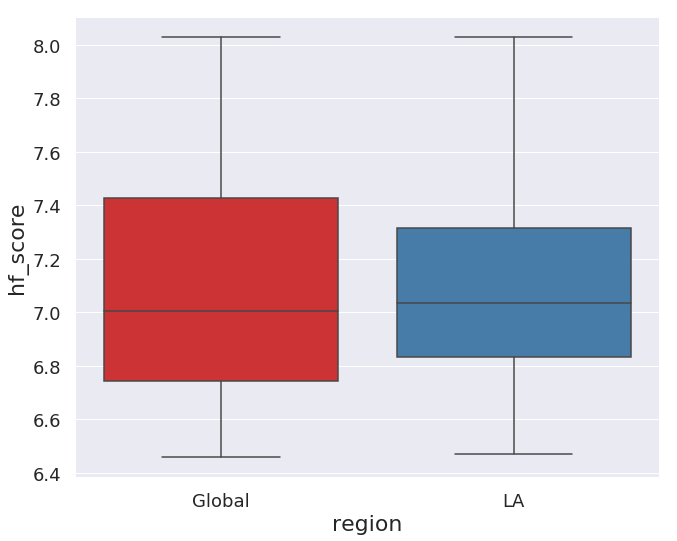

In [54]:
df7 = df6.copy()
df7 = df7.drop(df7[df7['hf_score'] < df7["hf_score"].quantile(0.25)].index)
df7 = df7.drop(df7[df7['hf_score'] > df7["hf_score"].quantile(0.75)].index)
sb.boxplot(x=df7['region'], y=df7['hf_score'], data=df7, palette="Set1")
plt.show()

El metodo utilizado para detectar ouliers es el grafico de caja y bigote. Se detectaron outliers en la variable **hf_score**. Lo que coincide con las concluciones presentadas en 1.3).

La Variable **pf_identity** presenta un sesgo hacia el tercer cuadril pero no se detectan ouliers.
Esto tambien coincide con los resultados obtenidos en 1.3).
Se puede comprobar en el ultimo caso que la eliminación de outliers para la variable **hf_score** no modifica drasticamente los valores de su media y cuartiles.


Veamos qué países son outliers para la variable hf_score

Global

In [343]:
mask = dataset['hf_score'] < 6.5
dataset[mask].sort_values(by='hf_score')[['year', 'countries', 'hf_score']].head(10)

,year,countries,hf_score
141,2016,Syria,3.765827
303,2015,Syria,3.910826
465,2014,Syria,4.023595
627,2013,Syria,4.095028
157,2016,Venezuela,4.200724
321,2015,"Yemen, Rep.",4.203442
319,2015,Venezuela,4.241750
159,2016,"Yemen, Rep.",4.253278
69,2016,Iraq,4.258014
86,2016,Libya,4.310283


Latinoamérica

In [341]:
mask = (dataset['region'] == 'Latin America & the Caribbean') & (dataset['hf_score'] < 6.5)
dataset[mask].sort_values(by='hf_score')[['year', 'countries', 'hf_score']].head(10)

,year,countries,hf_score
157,2016,Venezuela,4.200724
319,2015,Venezuela,4.241750
481,2014,Venezuela,4.573730
643,2013,Venezuela,5.013857
1129,2010,Venezuela,5.156619
805,2012,Venezuela,5.225650
1453,2008,Venezuela,5.257879
1291,2009,Venezuela,5.283514
967,2011,Venezuela,5.332458
327,2014,Argentina,6.207145


Vemos que, a nivel mundial, los outliers corresponden a Siria, mientras que en latinoamérica, corresponden a Venezuela. De hecho, el máximo histórico de Venezuela es significativamente menor que el mínimo histórico del resto de la región. 

In [372]:
mask = dataset['countries'] != 'Venezuela'
ven_max = dataset[mask].groupby(by='countries').max()[['year', 'hf_score']].sort_values(by='hf_score')['hf_score'][0]
print('Máximo histórico de hf_score para Venezuela: {:.2f}'.format(ven_max))

mask = (dataset['region'] == 'Latin America & the Caribbean') & (dataset['countries'] != 'Venezuela')
dataset[mask].groupby(by='countries').min().sort_values(by='hf_score')['hf_score'][0]
aux = dataset[mask].groupby(by='countries').min().sort_values(by='hf_score')[ 'hf_score']
region_min = aux.values[0]
pais = aux.index[0]
print('Mínimo histórico de hf_score para Latinoamérica y Caribe (excluyendo Venezuela): {:.2f} (correspondiente a {})'.format(region_min, pais))

Máximo histórico de hf_score para Venezuela: 4.26
Mínimo histórico de hf_score para Latinoamérica y Caribe (excluyendo Venezuela): 6.21 (correspondiente a Argentina)


Dado que se trata de un caso aislado y significativamente distinto al resto de la región, se podría excluir del análisis. 
La situación de Venezuela es particular en la región, dada la crisis económica y humanitaria que está atravezando. Posiblemente, su bajo índice de libertad humana esté relacionado con esta situación.

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Hint: hay un gráfico de seaborn que hace todo por vos!

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

**2.1)**

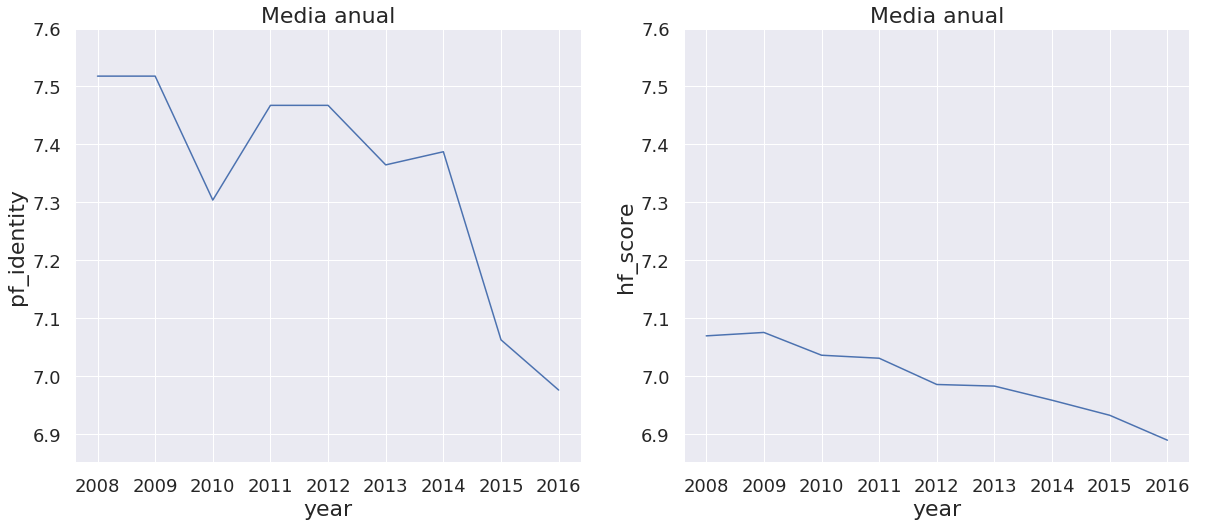

In [137]:
fig, axes = plt.subplots(figsize=(20, 8), ncols=2, nrows=1)    
for i, column in enumerate(['pf_identity', 'hf_score']):
    axes[i].set_ylim(6.85, 7.6)
    axes[i].set_title('Media anual')
    sb.lineplot(data=dataset, x='year', y=column, ci=None, ax=axes[i])
plt.show()

Las graficas demuestran que los valores medios de libertad personal y libertad humana a nivel global han disminuído en los ultimos años, auque no han sido descensos muy bruscos. Las escalas muestran variaciones de 0.5 puntos para la variable **pf_identity**  y de 0.175 puntos para la variable **hf_score** en una escala del 1-10.

In [182]:
paises_por_region = dataset['region'].value_counts()/ len(dataset['year'].unique())
paises_por_region

Sub-Saharan Africa               42.0
Latin America & the Caribbean    26.0
Eastern Europe                   22.0
Middle East & North Africa       19.0
Western Europe                   18.0
South Asia                       17.0
East Asia                         6.0
Caucasus & Central Asia           6.0
Oceania                           4.0
North America                     2.0
Name: region, dtype: float64

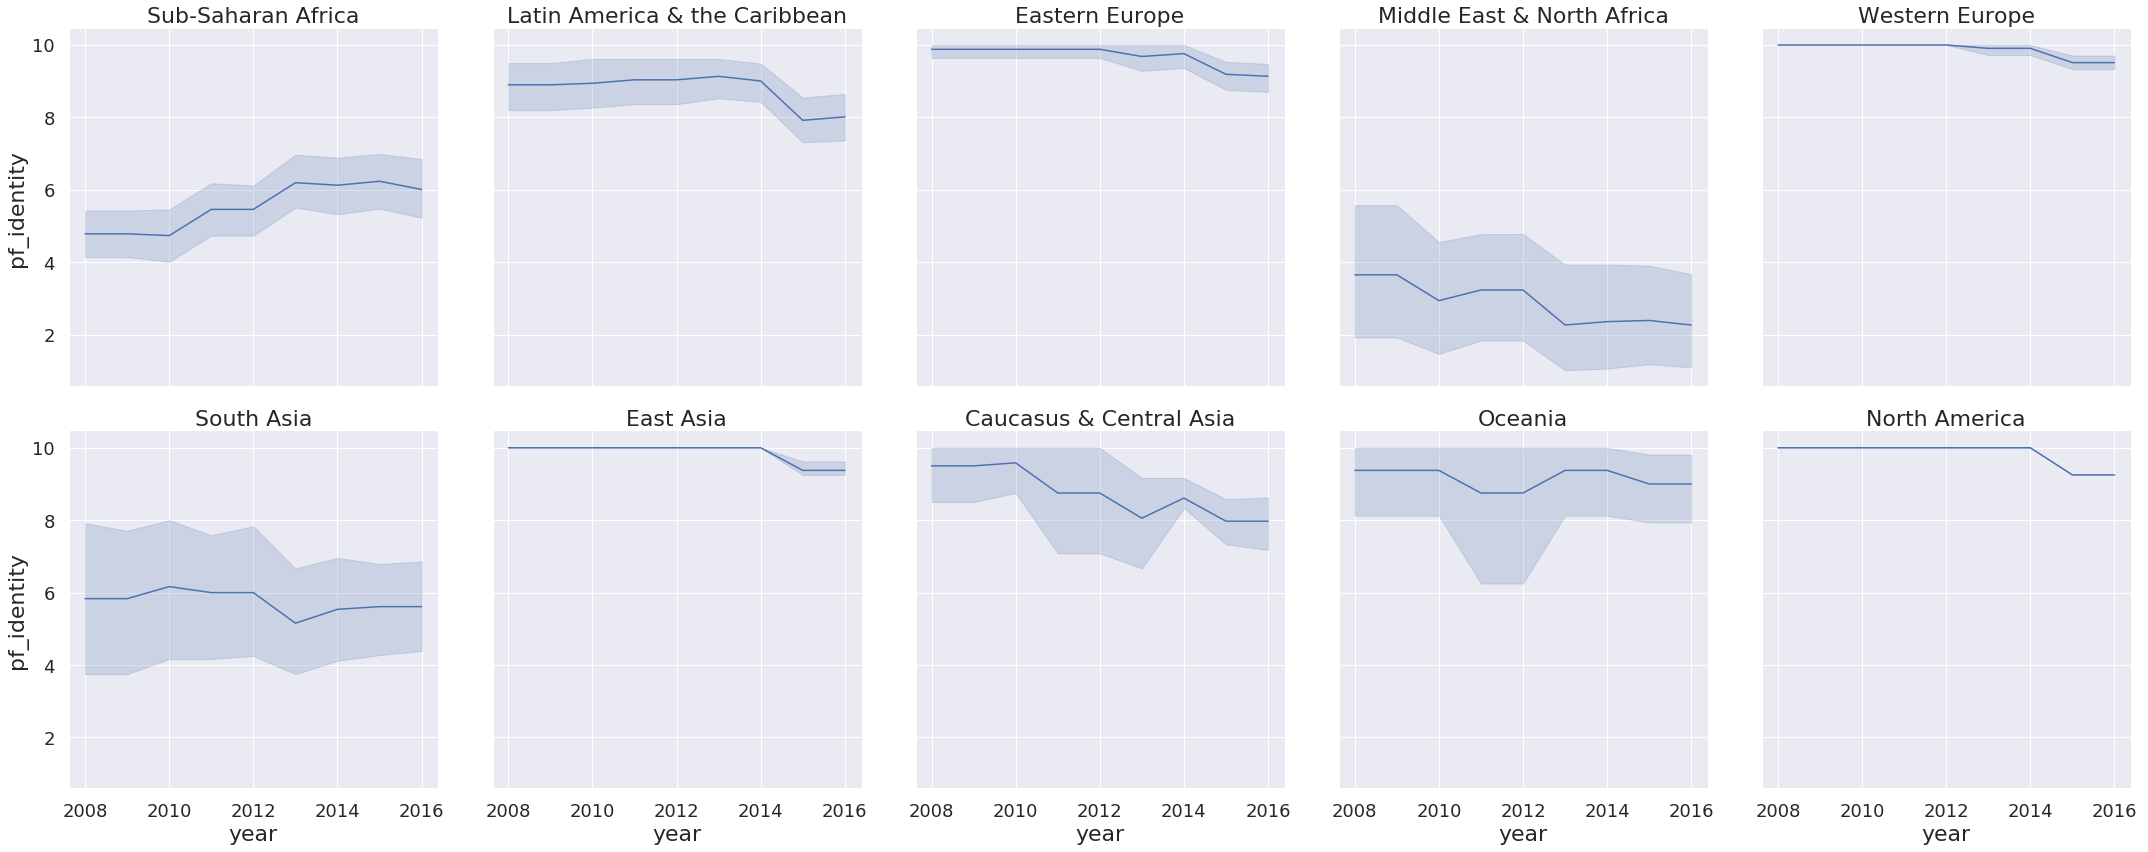

In [159]:
g = sb.FacetGrid(data=dataset, col='region', col_wrap=5, height=6, col_order=paises_por_region.index)
g.map(sb.lineplot, 'year', 'pf_identity').set_titles('{col_name}')
plt.show()

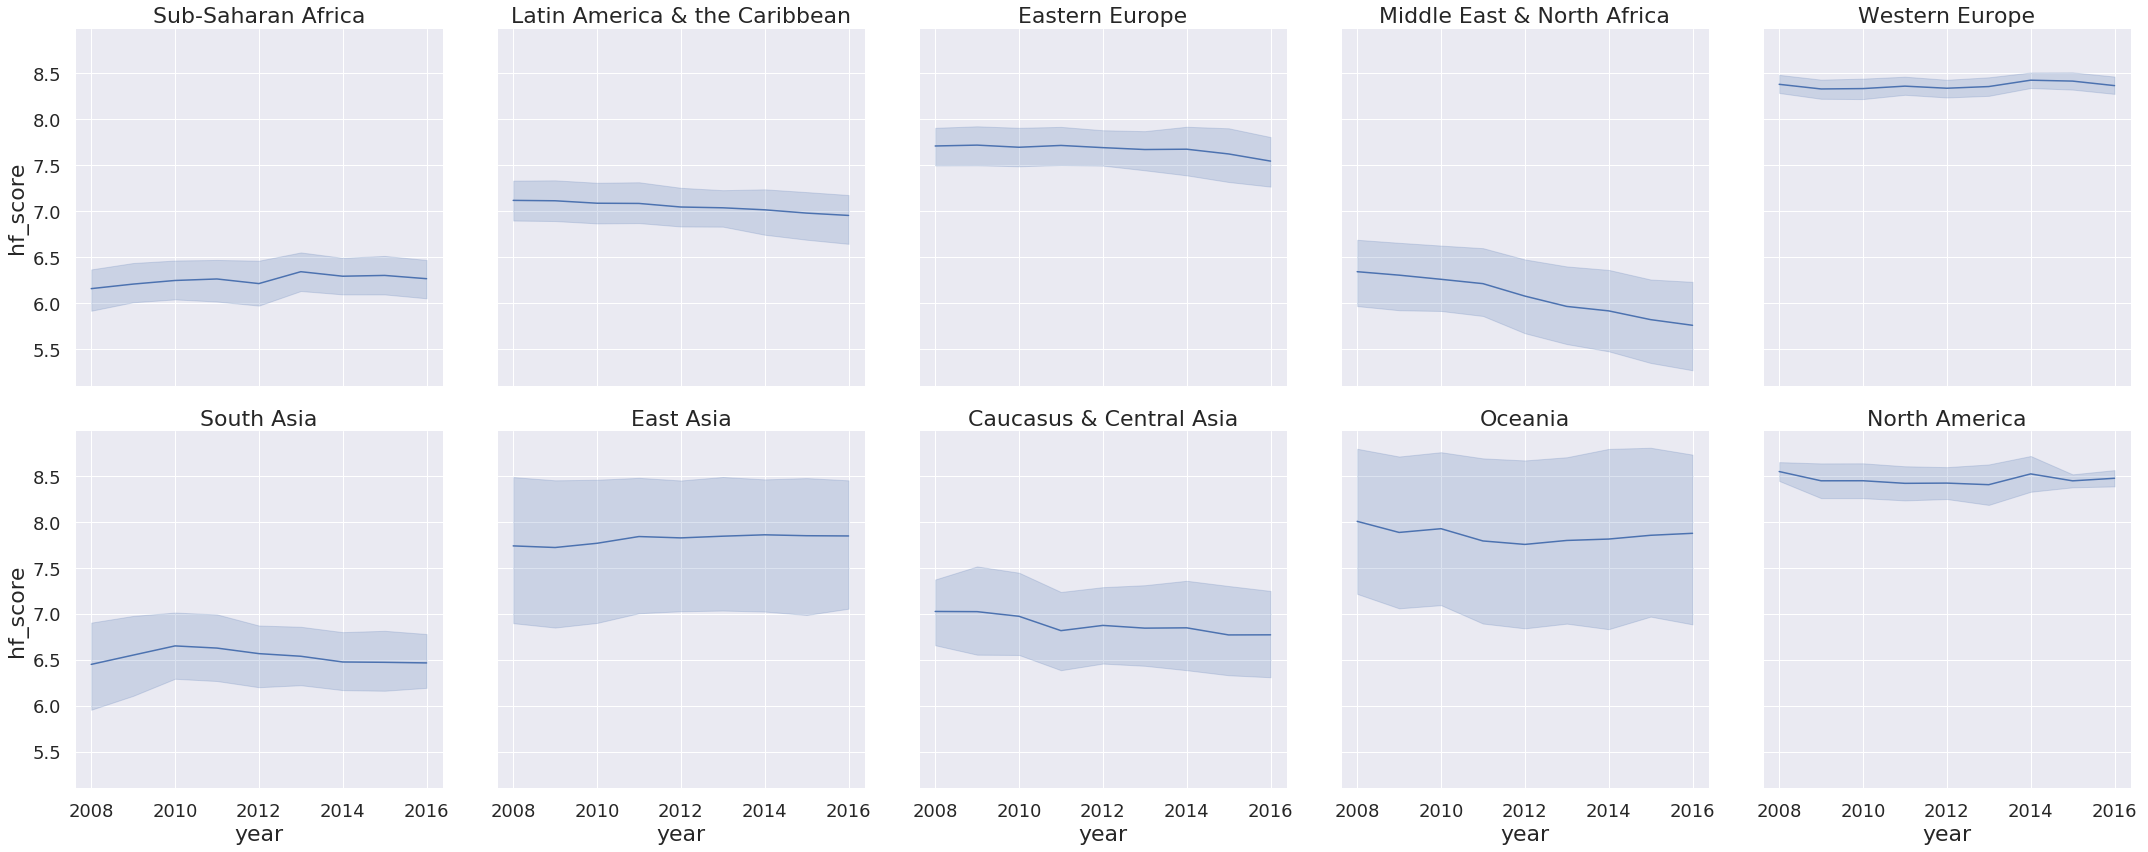

In [184]:
g = sb.FacetGrid(data=dataset, col='region', col_wrap=5, height=6, col_order=paises_por_region.index)
g.map(sb.lineplot, 'year', 'hf_score').set_titles('{col_name}')
plt.show()

**2.2)**

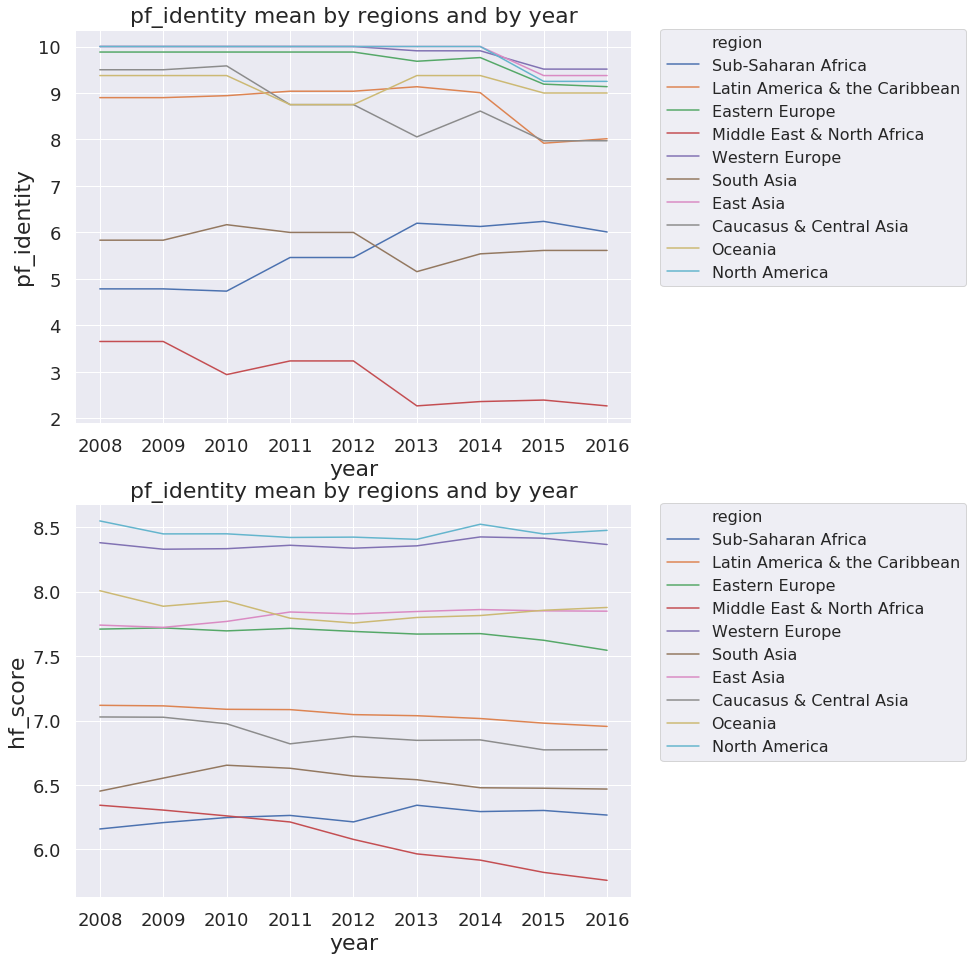

In [193]:
fig, axes = plt.subplots(figsize=(10, 16), ncols=1, nrows=2)    

for i, column in enumerate(['pf_identity', 'hf_score']):
    axes[i].set_title('pf_identity mean by regions and by year')
    sb.lineplot(data=dataset, x='year', y=column, hue='region', 
                hue_order=paises_por_region.index, ci=None, 
                ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.show()

Las graficas muestran que la baja en los promedios anivel global de las variables **pf_identity** y de **hf_score** se han ocacionado por la baja de dichas variables en algunas regiones en particular
Por ejemplo la variable **pf_identity** ha sido afectada por la region de **Middle East & Noth Africa** que perdio aproximadmente un punto. Tambien se observan bajas de aproximadamente medio punto en Oceania, Europa y Estados unidos

Con respecto a la variable **hf_score** tambien se nota una baja de aproximadamente un punto en **Middle East & Noth Africa**. Europa del Este y LatinAmerica tambien sufieron bajas de aproximadamente medio punto

**2.3)**
Se podría analizar como han evolucionado los paises que iniciaron con un mismo nivel de **personal freedom identity**
y ver como han evolucionado a traves de los años

In [452]:
sb.set(rc={'figure.figsize':(10.5,8.5)})

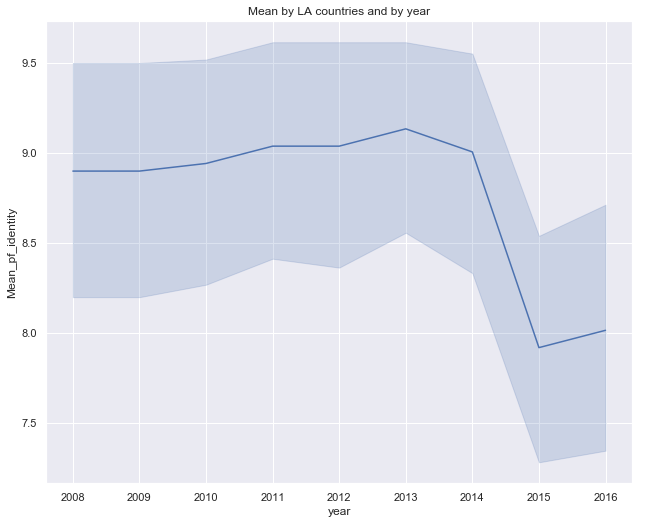

In [590]:
latin_america_countries = set(dataset[dataset['region'] == 'Latin America & the Caribbean']['countries'])

LA_data = pd.DataFrame()
for y in years:
    pf_identity_by_country = dict()
    for country in latin_america_countries:
        data_by_year_and_country = dataset[(dataset['year'] == y) & (dataset['countries'] == country)]
        pf_identity_mean =np.mean(data_by_year_and_country['pf_identity'].dropna())
        LA_data = LA_data.append({'year': y, 'country': country, 'Mean_pf_identity': pf_identity_mean}, ignore_index=True)
    
df_q1 = LA_data[LA_data['Mean_pf_identity'] <= 2.5]
df_q1_countries = set(df_q1['country'])

df_q2 = LA_data[(LA_data['Mean_pf_identity'] > 2.5) & (LA_data['Mean_pf_identity'] <= 5.0)]
df_q2 = df_q2[~df_q2.country.isin(df_q1_countries)]
df_q2_countries = set(df_q2['country'])

df_q3 = LA_data[(LA_data['Mean_pf_identity'] > 5.0) & (LA_data['Mean_pf_identity'] <= 7.5)]
df_q3 = df_q3[~df_q3.country.isin(df_q2_countries)]
df_q3_countries = set(df_q3['country'])

df_q4 = LA_data[(LA_data['Mean_pf_identity'] > 7.5) & (LA_data['Mean_pf_identity'] <= 10)]
df_q4 = df_q4[~df_q4.country.isin(df_q2_countries)]
df_q4 = df_q4[~df_q4.country.isin(df_q3_countries)]
df_q4_countries = set(df_q4['country'])


plt.title('Mean by LA countries and by year')
sb.lineplot(x='year', y='Mean_pf_identity', data=LA_data)
plt.show()

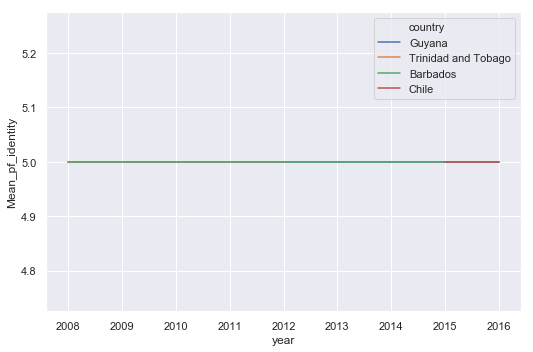

In [603]:
sb.lineplot(x='year', y='Mean_pf_identity', data=df_q2, hue='country')
plt.show()

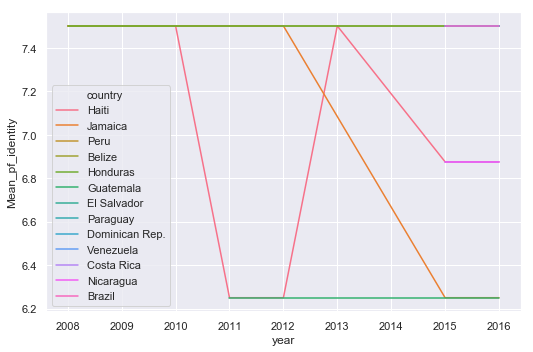

In [604]:
sb.lineplot(x='year', y='Mean_pf_identity', data=df_q3, hue='country')
plt.show()

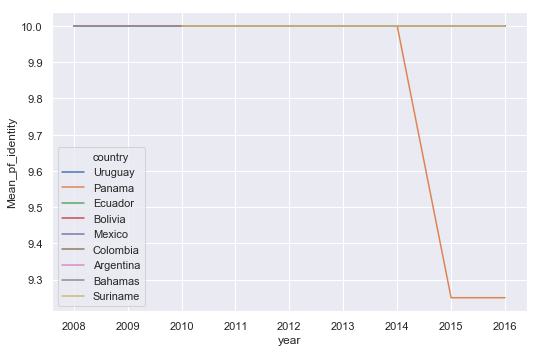

In [605]:
sb.lineplot(x='year', y='Mean_pf_identity', data=df_q4, hue='country')
plt.show()

**2.4)**

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

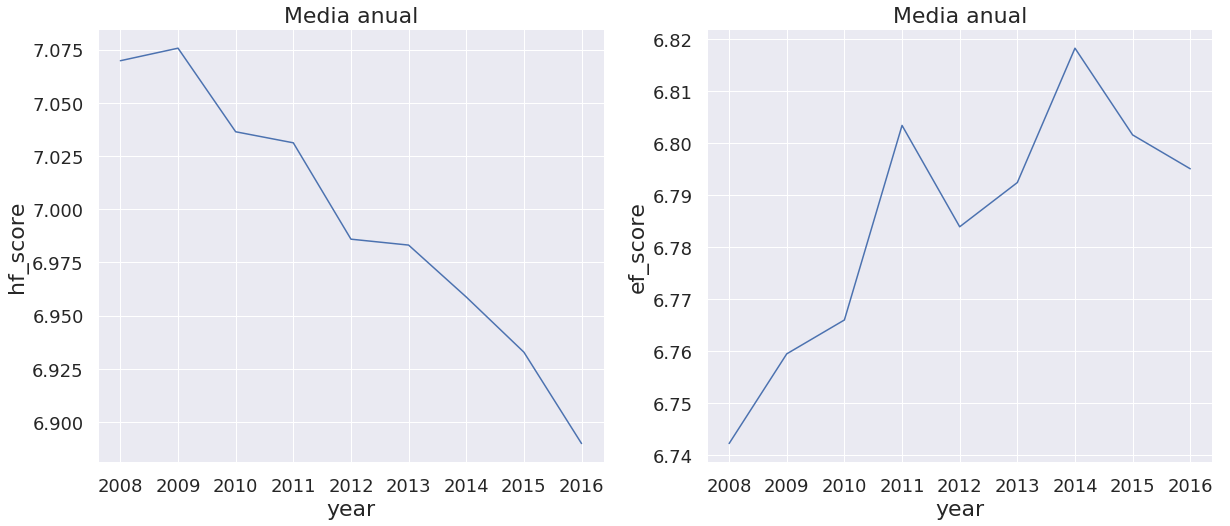

In [138]:
fig, axes = plt.subplots(figsize=(20, 8), ncols=2, nrows=1)    
for i, column in enumerate(['hf_score', 'ef_score']):
    axes[i].set_title('Media anual')
    sb.lineplot(data=dataset, x='year', y=column, ci=None, ax=axes[i])
plt.show()

### TODO COMPLETAR

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos los registros para esas zonas en estos gráficos?
  2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.
  3. Realizar un gráfico QQ de las mismas distribuciones. Se puede utilizar a,bas distribuciones sobre todos los datos o sólo sobre Latinoamérica, pero no cruzadas.
  4. Medir la asimetría (skew) y curtosis de las mismas distribuciones con las que realizó el gráfico anterior. ¿Cómo se relacionan estos estadísticos con la forma del gráfico QQ obtenido previamente? ¿El gráfico QQ provee más información que no esté presente en estos estadísticos?

**3.1)**

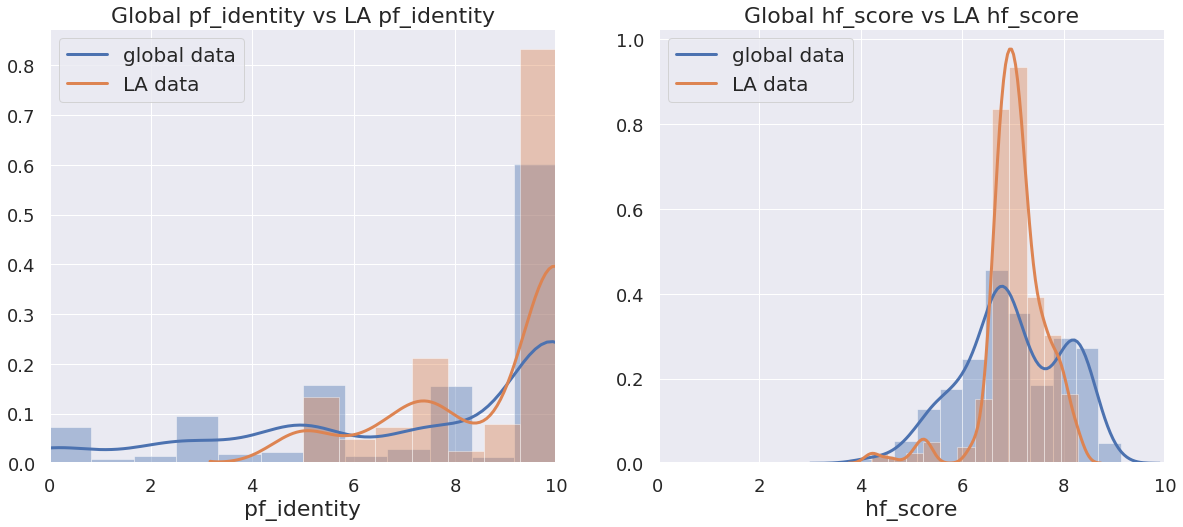

In [221]:
latin_america_data = dataset[dataset['region'] == 'Latin America & the Caribbean']

fig, axes = plt.subplots(figsize=(20,8), ncols=2, nrows=1)

ax = axes[0]
ax.set_xlim(0, 10)
clean_dataset = dataset['pf_identity'].dropna()
clean_latin_america_dataset = latin_america_data['pf_identity'].dropna()
sb.distplot(clean_dataset, kde_kws={"lw": 3, "label": "global data"}, ax=ax)
sb.distplot(clean_latin_america_dataset,  kde_kws={ "lw": 3, "label": "LA data"}, ax=ax)
ax.set_title('Global pf_identity vs LA pf_identity')

ax = axes[1]
ax.set_xlim(0, 10)
clean_dataset = dataset['hf_score'].dropna()
clean_latin_america_dataset = latin_america_data['hf_score'].dropna()
sb.distplot(clean_dataset, kde_kws={"lw": 3, "label": "global data"}, bins=12, ax=ax)
sb.distplot(clean_latin_america_dataset,  kde_kws={ "lw": 3, "label": "LA data"}, bins=12, ax=ax)
ax.set_title('Global hf_score vs LA hf_score')

plt.show()

La grafica de la variable **pf_identity** muestra al igual que su correspondiente grafica de caja y bigote 
(ploteada en ejercicio 1.5)
que los datos estan sesgados hacia la derecha. Lo mismo ocurre para la variable **hf_score**.
Para ninguna de las dos variables se percibe una simetria que haga suponer por ejemplo
que los datos se ajustan a dsitribuciones normales

**3.2)**

In [243]:
cleaned_global_pf_identity = dataset['pf_identity'].dropna()
normalized_global_pf_identity = (cleaned_global_pf_identity - cleaned_global_pf_identity.mean()) / cleaned_global_pf_identity.std()
stats.kstest(normalized_global_pf_identity, 'norm')

KstestResult(statistic=0.23673609609146884, pvalue=2.0004263167944867e-68)

In [239]:
cleaned_LA_pf_identity = latin_america_data['pf_identity'].dropna()
normalized_la_pf_identity = (cleaned_LA_pf_identity - cleaned_LA_pf_identity.mean()) / cleaned_LA_pf_identity.std()
stats.kstest(normalized_la_pf_identity, 'norm')

KstestResult(statistic=0.35088781204626546, pvalue=4.8166522633069314e-26)

In [277]:
clean_dataset = dataset['hf_score'].dropna()
normalized_global_hf_score = (clean_dataset - clean_dataset.mean()) / clean_dataset.std()
stats.kstest(normalized_global_hf_score, 'norm')
stats.kstest(clean_dataset, 'norm')

KstestResult(statistic=0.9999170006054449, pvalue=0.0)

In [241]:
clean_latin_america_dataset = latin_america_data['hf_score'].dropna()
normalized_la_hf_score = (clean_latin_america_dataset - clean_latin_america_dataset.mean()) / clean_latin_america_dataset.std()
stats.kstest(normalized_la_hf_score, 'norm')

KstestResult(statistic=0.1504746027707088, pvalue=4.737935317381503e-05)


Si aplico el test de K-S con los datos normalizados hay suficiente evidencia (dado que el p-valor es muy cercano a 0) para rechazar la hipotesis
de que las muestras se ajustan a una distribución normal. Esto confirma lo que indicaban los plots del punto 3.1,
pues para todos los casos ninguna de las funciones se asemeja a una campana de Gauss.

In [242]:
#TODO  revisar esto. los  plots de hf_score no son tan distintos de una normal y 
#ademas las graficas QQ parecen confirmaro

**3.3)**

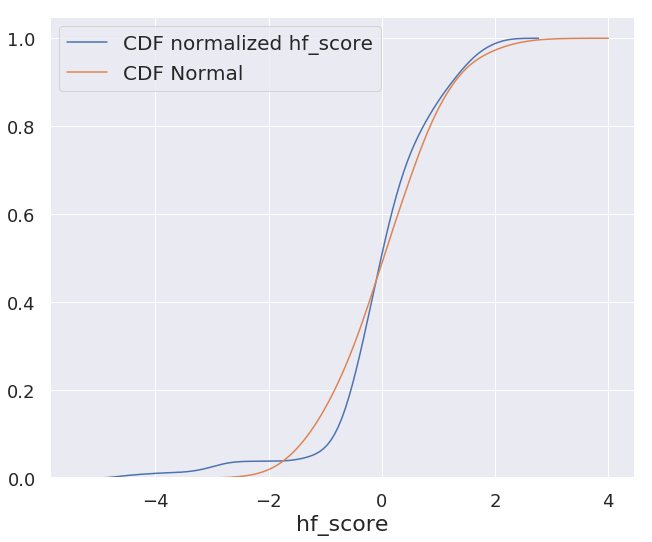

In [269]:
sb.distplot(normalized_global_hf_score, kde_kws={'cumulative': True}, hist=False, label='CDF normalized hf_score')
sb.distplot(a, kde_kws={'cumulative': True}, hist=False, label='CDF Normal')

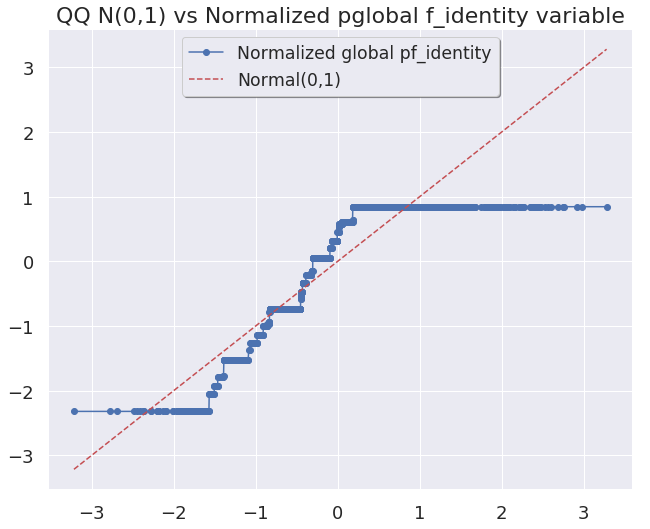

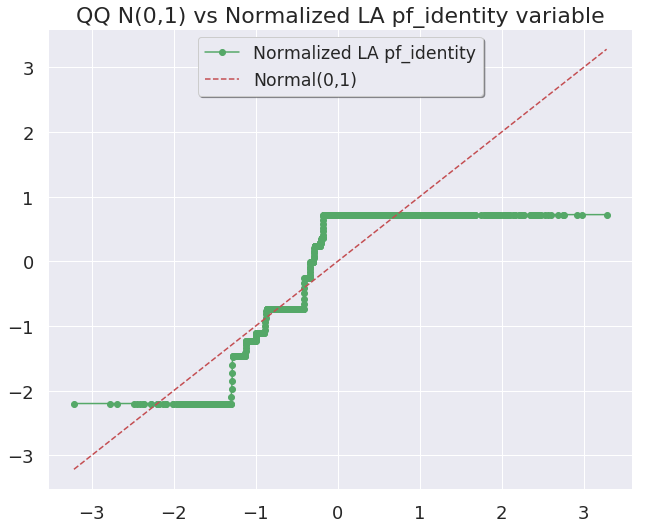

In [244]:
n = len(normalized_global_pf_identity)
a = np.random.normal(0, 1, n)

# Normalized global pf_identity
b = normalized_global_pf_identity
percs = np.linspace(0, 100, n)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)


plt.plot(qn_a, qn_b, marker="o", label='Normalized global pf_identity')

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x, x, color="r", ls="--",  label='Normal(0,1)')

legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('QQ N(0,1) vs Normalized pglobal f_identity variable')
plt.show()

# Normalized LA pf_identity
b = normalized_la_pf_identity
percs = np.linspace(0, 100, n)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)

plt.plot(qn_a, qn_b, marker="o", color="g", label='Normalized LA pf_identity')

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x, x, color="r", ls="--",  label='Normal(0,1)')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('QQ N(0,1) vs Normalized LA pf_identity variable')
plt.show()


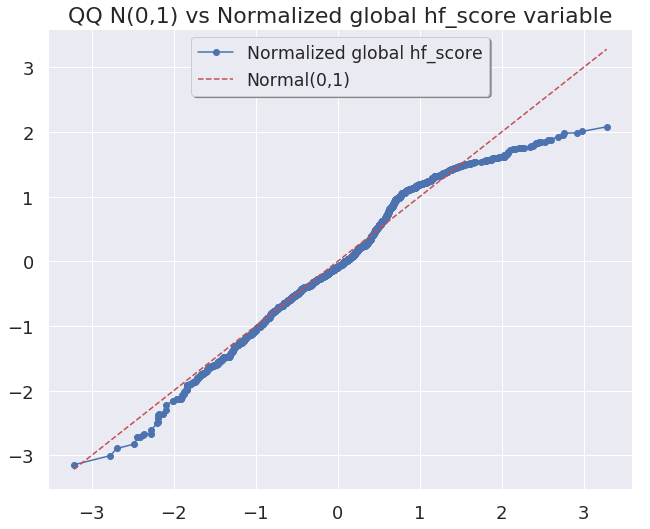

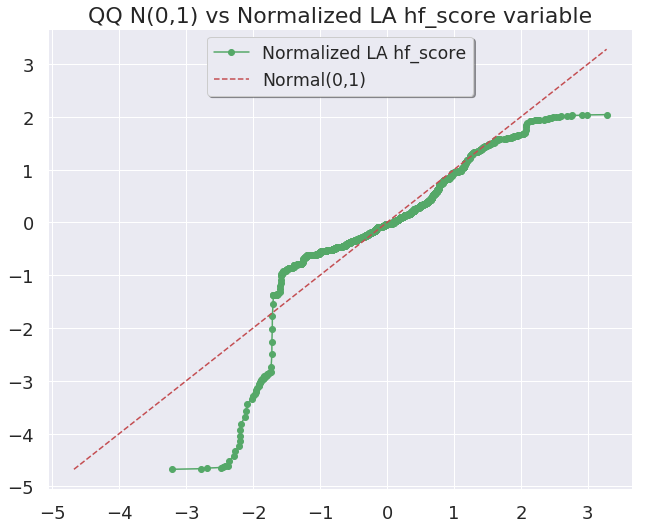

In [248]:
# Normalized global hf_score
b = normalized_global_hf_score
percs = np.linspace(0, 100, n)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)

plt.plot(qn_a, qn_b, marker="o", label='Normalized global hf_score')

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x, x, color="r", ls="--",  label='Normal(0,1)')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('QQ N(0,1) vs Normalized global hf_score variable')
plt.show()

# Normalized LA hf_score
b = normalized_la_hf_score
percs = np.linspace(0, 100, n)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)

plt.plot(qn_a, qn_b, marker="o", color="g", label='Normalized LA hf_score')

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x, x, color="r", ls="--",  label='Normal(0,1)')
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('QQ N(0,1) vs Normalized LA hf_score variable')
plt.show()

**3.4)**

In [465]:
from scipy.stats import kurtosis, skew
SEPARATOR = "="*80
print(SEPARATOR)
print("Normalized global pf_identity")
print('Excess kurtosis of normal distribution (should be 0): {0}'.format( kurtosis(normalized_global_pf_identity)))
print('Skewness of normal distribution (should be 0): {0}'.format( skew(normalized_global_pf_identity)))

print(SEPARATOR)
print("Nnormalized LA pf_identity")
print('Excess kurtosis of normal distribution (should be 0): {0}'.format( kurtosis(normalized_la_pf_identity)))
print('Skewness of normal distribution (should be 0): {0}'.format( skew(normalized_la_pf_identity)))

print(SEPARATOR)
print("Normalized global hf_score")
print('Excess kurtosis of normal distribution (should be 0): {0}'.format( kurtosis(normalized_global_hf_score)))
print('Skewness of normal distribution (should be 0): {0}'.format( skew(normalized_global_hf_score)))

print(SEPARATOR)
print("Normalized LA hf_score")
print('Excess kurtosis of normal distribution (should be 0): {0}'.format( kurtosis(normalized_la_hf_score)))
print('Skewness of normal distribution (should be 0): {0}'.format( skew(normalized_la_hf_score)))


Normalized global pf_identity
Excess kurtosis of normal distribution (should be 0): -0.4148322234251629
Skewness of normal distribution (should be 0): -0.9121780542847566
Nnormalized LA pf_identity
Excess kurtosis of normal distribution (should be 0): -0.2953048553672599
Skewness of normal distribution (should be 0): -1.047844021622469
Normalized global hf_score
Excess kurtosis of normal distribution (should be 0): -0.5101904315124792
Skewness of normal distribution (should be 0): -0.212051904376911
Normalized LA hf_score
Excess kurtosis of normal distribution (should be 0): 5.340188962725749
Skewness of normal distribution (should be 0): -1.4420921513321425


Poner aca algunas  concluciones, la Normalized global hf_score es Normal segun los ultimos 2 expermientos
hay qye ver por que KS dio un p-valor tan bajo

El QQ plot brinda siempre más información que la kurtosis y la skewness, ya que nos muestra el comportamiento de todo el conjunto de datos con respecto a la distribución que queremos comparar. En cambio, la kurtosis y la skewness nos brindan una información parcial.

## 4. Correlaciones

En este ejercicio queremos responder a las preguntas

* Las libertades sociales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades individuales y respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, hf_score y ef_score. 

Como pf_indentity contribuye al cálculo de hf_score y ef_score, esperamos hallar algún grado de correlación. Sin embargo, queremos medir qué tanta correlación. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación entre pf_identity y hf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en efecto, discreta.
3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el hf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros)


**4.1)**

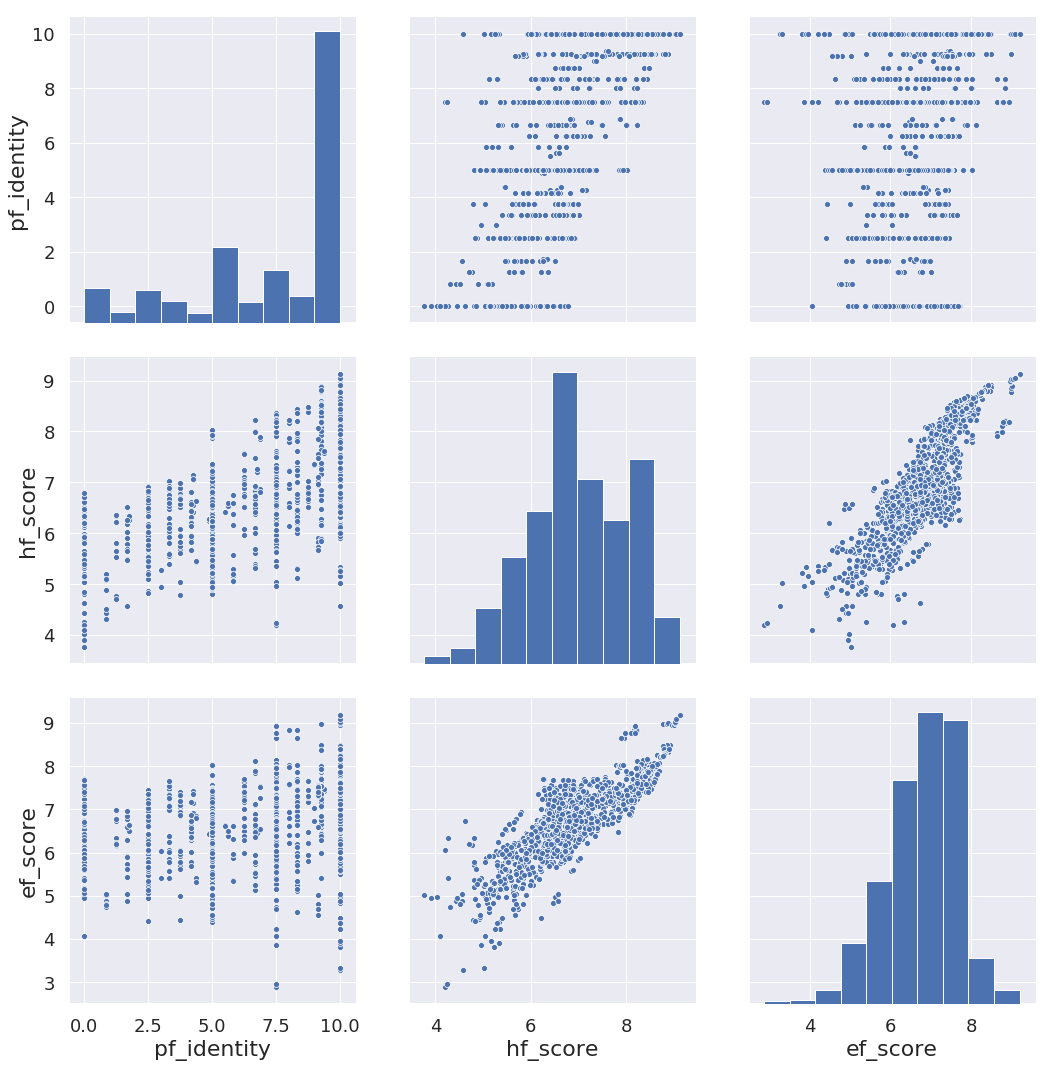

In [284]:
sb.pairplot(dataset, vars=['pf_identity','hf_score', 'ef_score'], height=5)

El gráfico de correlación no es el más adecuado para la variable hf_identity, ya que la mayoría de los datos contienen un valor igual a 10. Eso hace que tengamos muy pocos datos en el resto del rango para comparar. Haciendo esta salvedad, podemos observar que existe una correlación entre esta variable y hf_score, pero no puede observarse una clara correlación con ef_score. Con respecto a las otras dos variables, existe una marcada correlación entre las mismas.

**4.2)**

Text(0.5, 1.05, 'pf_identity vs hf_score')

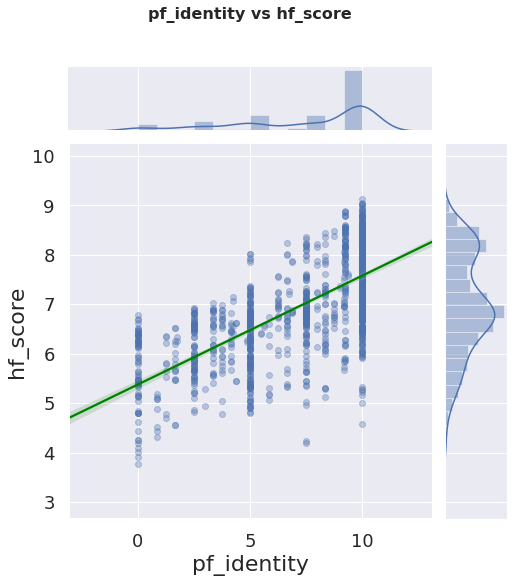

In [285]:
g = sb.jointplot(x=dataset['pf_identity'], y=dataset['hf_score'],
                 data=dataset, kind="reg",
                 line_kws={'color':'green'},
                 scatter_kws={'alpha': 0.33})
g.fig.set_size_inches(8, 8)
g.fig.suptitle("pf_identity vs hf_score",
               fontsize=16, weight="bold", y=1.05)

Text(0.5, 1.05, 'pf_identity vs ef_score')

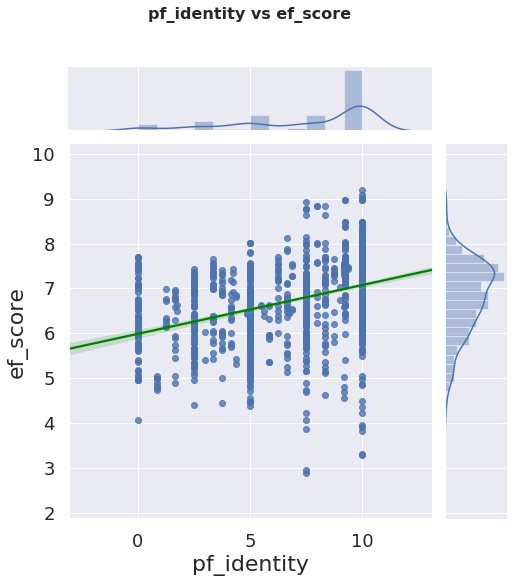

In [286]:
g = sb.jointplot(dataset['pf_identity'], y=dataset['ef_score'],
                  data=dataset, kind="reg",
                  line_kws={'color':'green'})
g.fig.set_size_inches(8, 8)
g.fig.suptitle("pf_identity vs ef_score",
               fontsize=16, weight="bold", y=1.05)

## 4.3) TODO  COMPLETAR


In [290]:
df[['pf_identity', 'hf_score', 'ef_score']].corr(method='spearman')

,pf_identity,hf_score,ef_score
pf_identity,1.000000,0.686109,0.426993
hf_score,0.686109,1.000000,0.860647
ef_score,0.426993,0.860647,1.000000


## 4.4) TODO  COMPLETAR


## Conclusiones y respuestas a las subpreguntas planteadas en la descripcción del problema

Conclusiones:

    1) ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.


    2)¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?


    3)Estos dos estimadores, ¿se relacionan de la misma manera con la libertad de identidad?
